
# Version 1 - Fundamental
## w/o uncertainty of RES and clearing fee
### Author: Junhyeok Kim

In [1]:
# Import the library

import os
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})

In [2]:
# Define the Variables
BASE_DIR = os.getcwd()
os.chdir("../")
path = os.getcwd() 
sys.path.append(path) # 폴더 두 단계 위에서 file import 하기 위해서 sys path 설정

from aggregator import aggregator
from gurobiMILP import gurobi_MILP
from draw_fig import Opt_Bid_Plot

In [3]:


# Data generated from the date 221030 
wt_dataset = pd.read_excel(f"{path}/data/비중앙 실적.xlsx", 1, header=1)
wt_data = wt_dataset.iloc[-2, 1:-2].values
wt_profile = wt_data / np.max(wt_data)
wt_profile = wt_profile.astype(float)
wt_profile = np.maximum(wt_profile, 1e-6)

pv_dataset = pd.read_excel(f"{path}/data/비중앙 실적.xlsx", 2, header=1)
pv_data = pv_dataset.iloc[-2, 1:-2].values
pv_profile = pv_data / np.max(pv_data).astype(float)
pv_profile = pv_profile.astype(float)
pv_profile = np.maximum(pv_profile, 1e-6)

da_smp_dataset = pd.read_excel(f"{path}/data/smp_jeju_2022.xlsx", header=1)
da_smp_data = da_smp_dataset.loc[da_smp_dataset['구분']== 20221030]
da_smp_profile= da_smp_data.iloc[0,1:1+24].values
da_smp_profile = da_smp_profile.astype(float)

print("Display WT, PV, DA_SMP Profile")
display(wt_profile, pv_profile, da_smp_profile)

Display WT, PV, DA_SMP Profile


array([ 0.251355,  0.290609,  0.392466,  0.452870,  0.474049,  0.541380,
        0.713243,  0.707066,  0.772422,  0.544620,  0.079141,  0.126149,
        0.108657,  0.122997,  0.196914,  0.573056,  0.869784,  1.000000,
        0.998045,  0.834849,  0.742808,  0.654308,  0.603574,  0.747760])

array([ 0.000423,  0.000407,  0.000374,  0.000363,  0.000358,  0.000363,
        0.000477,  0.070437,  0.386254,  0.709651,  0.904545,  1.000000,
        0.998997,  0.907256,  0.797912,  0.515076,  0.230750,  0.025176,
        0.003318,  0.002179,  0.000001,  0.000092,  0.000461,  0.000455])

array([ 258.300000,  232.600000,  213.100000,  207.750000,  213.250000,
        213.250000,  213.100000,  212.800000,  212.650000,  213.760000,
        204.700000,  211.140000,  211.140000,  210.510000,  208.000000,
        207.590000,  210.510000,  257.690000,  283.370000,  258.120000,
        258.160000,  257.800000,  258.280000,  257.040000])

In [4]:
# Define the Parameters

# case_dict: Generate various scenario
# res_var: Define the WT and PV as variables [True] or parameters [False]
# case:
    # case 1 : w/o uncertainty
    # case 2 : w uncertainty
    
case_dict = {'res_var': True, 'case':1, 'UNIT_TIME': 1, 'bid_type': 'deterministic'}

nTimeslot = int(24 / case_dict['UNIT_TIME'])
char_ess = {'initSOC':0.5, 'termSOC':0.5, 'minSOC':0.2, 'maxSOC':0.8, 'efficiency':0.95}
model_dict = {'nVPP':1, 'da_smp': da_smp_profile, 'nTimeslot': nTimeslot}

# Set Up VPP  #Unit: kW

vpp_list = []
for i in range(model_dict['nVPP']):
    nGen_dict = {'WT':1,'PV':2, 'ESS':1}
    
    wt_list = [1000]
    pv_list = [3000, 2000]
    ess_list = [1000]
    capacity_list = [3000] 
    max_list = [wt_list, pv_list, ess_list, capacity_list]
    
    agg_dict = {'name': f'cvpp{i+1}', 'code': f'xds{i+1}', 'gen':nGen_dict,
                'profile': [wt_profile, pv_profile]}
    vpp_list.append(aggregator(agg_dict, char_ess, model_dict))
    vpp_list[i].set_der_power(max_list)

Error
'uncertainty'
Class Aggregator
No Uncertainty Sets in this cases
No Uncertainty Sets in this cases
No Uncertainty Sets in this cases
Error
'aggregator' object has no attribute 'wt_uncert'
Aggregator set_res_table method
Uncertainty does not exist
Uncertainty does not exist
Uncertainty does not exist


In [5]:
# Gurobi Optimization Model
opt_bid = gurobi_MILP('opt bid', vpp_list[0], model_dict, case_dict)
opt_bid.add_Parameters()
opt_bid.add_Variables()
opt_bid.add_bid_constraints()
opt_bid.add_smp_constraints()
opt_bid.add_res_constraints()
opt_bid.add_ess_contraints()
opt_bid.set_Objectives()

mip_gap = 0.0001
feas_tol = 1e-4
sol, obj = opt_bid.solve([mip_gap, feas_tol])



case 1 add Variables
gurobi_MILP add Variables
No Uncertainty Sets in this case

Assign P_wt in No uncertainty
Assign P_pv in No uncertainty
Does not Cosidered alpha
ADD smp constraints as fixed
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 217 rows, 192 columns and 1608 nonzeros
Model fingerprint: 0xf41cd21f
Variable types: 144 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [2e+02, 3e+02]
  Bounds range     [1e+00, 7e+03]
  RHS range        [2e-03, 3e+03]
Found heuristic solution: objective 9895960.6464
Presolve removed 122 rows and 118 columns
Presolve time: 0.01s
Presolved: 95 rows, 74 columns, 1080 nonzeros
Variable types: 50 continuous, 24 integer (24 binary)

Root relaxation: 

In [6]:
P_dict, U_dict = opt_bid.get_sol()

In [7]:
P_dict

{'bid': array([ 1108.468924,  292.642017,  394.336550,  454.686460,  475.838251,
         543.196154,  715.628667,  1059.248333,  2703.692852,  4092.872983,
         3601.866471,  5126.149176,  5103.642844,  4659.275231,
         4186.473065,  2253.699727,  2023.532476,  1125.878220,
         1869.633179,  845.745790,  742.813223,  654.769051,  605.878215,
         750.036885]),
 'essDis': array([[ 855.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  855.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000]]),
 'essChg': array([[ 0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  1000.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  894.736842,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,

No Uncertainty Sets in this case - Opt_Bid_Plot_init


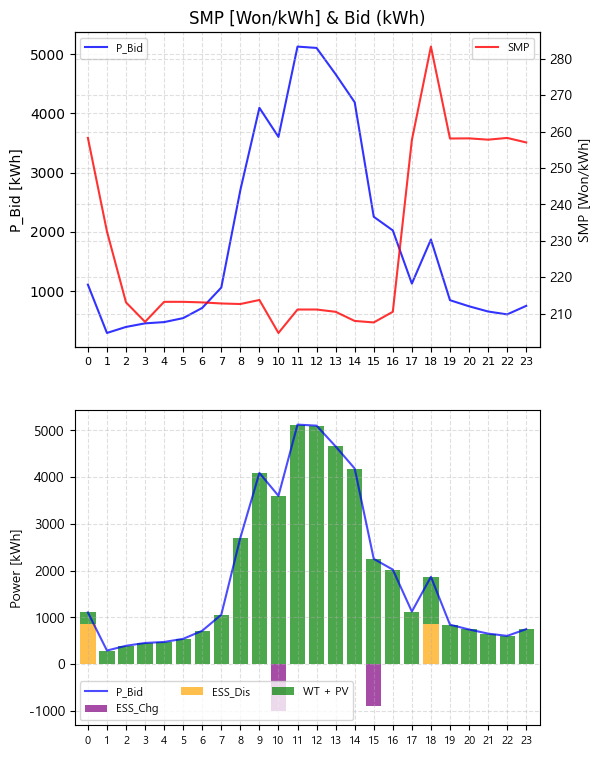

<Figure size 600x450 with 0 Axes>

In [8]:
# Draw the Plots

bid_plot = Opt_Bid_Plot(vpp_list, opt_bid, model_dict, case_dict, path)
bid_plot.make_plot(P_dict)

In [9]:
P_dict, U_dict = opt_bid.get_sol()
display(P_dict)

{'bid': array([ 1108.468924,  292.642017,  394.336550,  454.686460,  475.838251,
         543.196154,  715.628667,  1059.248333,  2703.692852,  4092.872983,
         3601.866471,  5126.149176,  5103.642844,  4659.275231,
         4186.473065,  2253.699727,  2023.532476,  1125.878220,
         1869.633179,  845.745790,  742.813223,  654.769051,  605.878215,
         750.036885]),
 'essDis': array([[ 855.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  855.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000]]),
 'essChg': array([[ 0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  1000.000000,
          0.000000,  0.000000,  0.000000,  0.000000,  894.736842,
          0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,

In [10]:
opt_bid.P_wt

{(0, 0): <gurobi.Var P_wt[0,0] (value 251.35469058575165)>,
 (0, 1): <gurobi.Var P_wt[0,1] (value 290.6091000184841)>,
 (0, 2): <gurobi.Var P_wt[0,2] (value 392.4662665019311)>,
 (0, 3): <gurobi.Var P_wt[0,3] (value 452.8703874852857)>,
 (0, 4): <gurobi.Var P_wt[0,4] (value 474.0492844704303)>,
 (0, 5): <gurobi.Var P_wt[0,5] (value 541.3800819137863)>,
 (0, 6): <gurobi.Var P_wt[0,6] (value 713.243377338483)>,
 (0, 7): <gurobi.Var P_wt[0,7] (value 707.0657936978918)>,
 (0, 8): <gurobi.Var P_wt[0,8] (value 772.4217100718935)>,
 (0, 9): <gurobi.Var P_wt[0,9] (value 544.6196651457811)>,
 (0, 10): <gurobi.Var P_wt[0,10] (value 79.14116994678523)>,
 (0, 11): <gurobi.Var P_wt[0,11] (value 126.14917648432255)>,
 (0, 12): <gurobi.Var P_wt[0,12] (value 108.65737272718428)>,
 (0, 13): <gurobi.Var P_wt[0,13] (value 122.99714955589496)>,
 (0, 14): <gurobi.Var P_wt[0,14] (value 196.9141267231567)>,
 (0, 15): <gurobi.Var P_wt[0,15] (value 573.0560068488486)>,
 (0, 16): <gurobi.Var P_wt[0,16] (value 8

In [11]:
#Initialize Model
bid_plot.P_wtSol + sum(bid_plot.P_pvSol)

array([[ 253.468924,  292.642017,  394.336550,  454.686460,  475.838251,
         543.196154,  715.628667,  1059.248333,  2703.692852,
         4092.872983,  4601.866471,  5126.149176,  5103.642844,
         4659.275231,  4186.473065,  3148.436569,  2023.532476,
         1125.878220,  1014.633179,  845.745790,  742.813223,
         654.769051,  605.878215,  750.036885]])

In [12]:
# Run the Optimization
27.871010,  32.180457,  43.367669,  50.006430,  52.333263,
         59.742497,  78.707227,  114.756404,  287.749858,  432.474762,
         483.591685,  513.876409,  511.952311,  489.838885,  440.564242,
         333.451120,  216.819832,  113.217213,  101.741803,  92.977555,
         81.709429,  72.022292,  66.635084,  82.492673


IndentationError: unexpected indent (1503854142.py, line 3)